In [1]:
# import modules/packages
import os
os.environ['TF_CP_MIN_LOG_LEVEL'] = '2'

#from google.colab import drive
#drive.mount('/content/drive')

import sys
import psutil
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

In [2]:
# check GPU availability
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 16 15:40:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# check RAM availability
ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# load the synthetic 5-mers data
data_dir = '/content/drive/MyDrive/5-mer_data'

with open(os.path.join(data_dir, '009.2.5mer.feature.pkl'), 'rb') as file:
    syn_X = pickle.load(file)
print(syn_X.shape)

with open(os.path.join(data_dir, '009.1.mid.position.base.array.pkl'), 'rb') as file:
    syn_y =pickle.load(file)
print(syn_y.shape)

(214966, 5, 7)
(214966, 5)


In [4]:
# load mouse BrdU-free 5-mer data
mouse_T_X = np.load(os.path.join(data_dir, "mouse.combined_array.npy"))

In [5]:
mouse_y = np.full((mouse_T_X.shape[0], 1), "T")

# convert dummies using the universe ["A", "B" "C", "G", "T"]
aplhabets = np.array(["A", "B", "C", "G", "T"]).reshape(5, 1)
mouse_y_p = np.vstack((aplhabets, mouse_y), dtype=object)
mouse_y = pd.get_dummies(mouse_y_p.ravel(), dtype=float).values

# remove the first 5 rows
mouse_y = mouse_y[5:, :]
print(mouse_y)
print(mouse_y.shape)
# save mouse label
np.save(os.path.join(data_dir, "mouse.combined_label.npy"), mouse_y)

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
(8279453, 5)


In [6]:
mouse_T_X, mouse_y = shuffle(mouse_T_X, mouse_y, random_state= 42 )
mouse_T_X_select, mouse_T_y_select = mouse_T_X[0:800000, :, :], mouse_y[0:800000, :]
print(mouse_T_X_select.shape)
print(mouse_T_y_select.shape)

(800000, 5, 7)
(800000, 5)


In [7]:
#combine mouse_T_X_select and syn_X
X = np.concatenate((syn_X, mouse_T_X_select), axis=0)

#combine syn_y and mouse_T_y_select
y = np.concatenate((syn_y, mouse_T_y_select), axis=0)
print(X.shape)
print(y.shape)

(1014966, 5, 7)
(1014966, 5)


In [8]:
# shuffle and split X, and y
X, y = shuffle(X, y, random_state= 42 )

# split _x and _y for training (60%),validation (20%), and testing (20%)
X_train_tmp, X_test, y_train_tmp, y_test = \
         train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = \
         train_test_split(X_train_tmp, y_train_tmp,
                          test_size=0.11, random_state=42)

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(812987, 5, 7)
(812987, 5)
(100482, 5, 7)
(100482, 5)
(101497, 5, 7)
(101497, 5)


In [9]:
# determine class weights for unbalanced data
y_train_labels= np.where(y_train==1)[1]
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train_labels),
                                                  y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: np.float64(3.6416806647405315), 1: np.float64(7.097223919685727), 2: np.float64(3.72442907208466), 3: np.float64(4.94367284889024), 4: np.float64(0.24308868094623706)}


In [39]:
kmer_size = 5
feature_dimension = 7
gru_units = 128
output_dimension = 5

In [40]:
model = keras.Sequential([
    # tf.keras.Input()-- instantiate a Keras tensor
    # In TensorFlow Keras, input layers are essential for defining the expected
    # shape and data type of input data for a neural network. There are two primary
    #  ways to define input layers: keras.Input and keras.layers.InputLayer.
    # --keras.Input: This approach is often favored for its conciseness and flexibility,
    #  especially when building models using the Functional API. It directly creates a
    # symbolic tensor-like object representing the input.
    # Define an input layer for a sequence of 5 time steps with 7 features each
    # None for batch size
    keras.Input(shape = (kmer_size,feature_dimension), dtype = "float32"),
    layers.Bidirectional(layers.GRU(units= gru_units, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units= gru_units, return_sequences=True)),
    layers.Bidirectional(layers.GRU(units= gru_units)),
    layers.Dense(units = output_dimension, activation='softmax')
])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 5, 256)         │       105,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 5, 256)         │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,397 (2.67 MB)

 Trainable params: 699,397 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [41]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              # If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss
              # from_logits in keras.losses.CategoricalCrossentropy should be set to True when the
              # output of your model's last layer has not passed through a softmax
              # activation function.
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction='sum_over_batch_size',
                    name='categorical_crossentropy'
                  ),
              loss_weights = None,
              metrics=['categorical_accuracy', 'precision', 'recall',
                       keras.metrics.AUC(name='prc', curve='PR')])

In [42]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# An epoch in Machine Learning, is the entire processing
# by the learning algorithm of the entire train-set.
history = model.fit(X_train, y_train,
          validation_data = (X_val, y_val),
          batch_size = 128,
          epochs = 30,
          class_weight = class_weights_dict,
          callbacks = [early_stopping],
          verbose = 2)

Epoch 1/30
6352/6352 - 70s - 11ms/step - categorical_accuracy: 0.8526 - loss: 0.1985 - prc: 0.9406 - precision: 0.8628 - recall: 0.8447 - val_categorical_accuracy: 0.8342 - val_loss: 0.3937 - val_prc: 0.9235 - val_precision: 0.8352 - val_recall: 0.8323
Epoch 2/30
6352/6352 - 65s - 10ms/step - categorical_accuracy: 0.9145 - loss: 0.1209 - prc: 0.9750 - precision: 0.9154 - recall: 0.9132 - val_categorical_accuracy: 0.9083 - val_loss: 0.2219 - val_prc: 0.9719 - val_precision: 0.9094 - val_recall: 0.9070
Epoch 3/30
6352/6352 - 64s - 10ms/step - categorical_accuracy: 0.9263 - loss: 0.1061 - prc: 0.9805 - precision: 0.9271 - recall: 0.9252 - val_categorical_accuracy: 0.9329 - val_loss: 0.1723 - val_prc: 0.9826 - val_precision: 0.9337 - val_recall: 0.9322
Epoch 4/30
6352/6352 - 64s - 10ms/step - categorical_accuracy: 0.9318 - loss: 0.0973 - prc: 0.9829 - precision: 0.9327 - recall: 0.9310 - val_categorical_accuracy: 0.9438 - val_loss: 0.1473 - val_prc: 0.9871 - val_precision: 0.9448 - val_rec

In [43]:
model.save(os.path.join(data_dir, '001.DeepBrdU.w.Synthetic.mouse.5mer-20250716-0259.keras'))

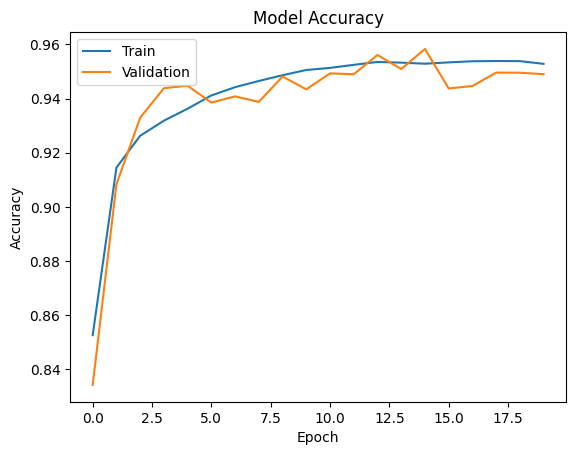

In [44]:
## plot accuracy curve
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

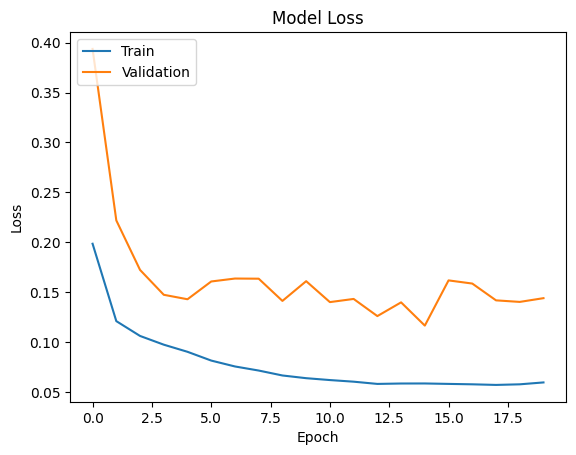

In [45]:
## plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [46]:
model.evaluate(X_test, y_test,
               batch_size = 128,
               verbose = 2)

793/793 - 4s - 5ms/step - categorical_accuracy: 0.9588 - loss: 0.1156 - prc: 0.9911 - precision: 0.9594 - recall: 0.9585


[0.11559499055147171,
 0.9588165283203125,
 0.9593601822853088,
 0.9584716558456421,
 0.9911190271377563]

In [11]:
#load model
data_dir = '/content/drive/MyDrive/5-mer_data'
model = keras.models.load_model(os.path.join(data_dir, '001.DeepBrdU.w.Synthetic.mouse.5mer-20250716-0259.keras'))

In [12]:
## confusion matrix mouse_x, mouse_x, mouse_label
labels= np.where(y_test ==1)[1]
predictions = model.predict(X_test)

3172/3172 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step


In [2]:
def softmax_to_label(softmax_output):
  """Converts softmax probabilities to a label encoded value.

  Args:
    softmax_output: A list or numpy array of probabilities.

  Returns:
    The index of the highest probability.
  """
  return np.argmax(softmax_output)

In [13]:
predictions_label = np.apply_along_axis(softmax_to_label,  1, predictions)
print(len(predictions_label))
confusion_matrix = tf.math.confusion_matrix(labels,
                                           predictions_label,
                                           num_classes=5)

# Print the confusion matrix
print(confusion_matrix.numpy())

101497
[[ 5495    29    12    12     7]
 [    3  2420    10     5   340]
 [    7     8  5382    12     7]
 [    9    11     2  4111     3]
 [   23  3631    15    34 79909]]


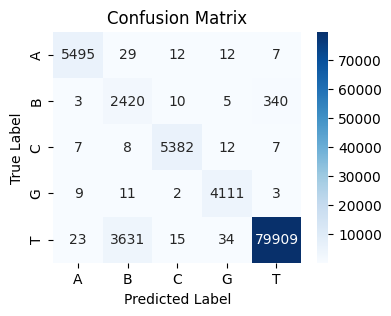

In [14]:
class_names = ["A","B", "C", "G", "T"]
def plot_confusion_matrix(cm, class_names, outfilename):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig(outfilename)
    plt.show()

outfilename = '/content/drive/MyDrive/5-mer_data/Fig001.syn.mouse.5mers.retained.model.predicting.x-test.confusion.matrix.pdf'
plot_confusion_matrix(confusion_matrix.numpy(), class_names, outfilename)